# Modelling the behavior of a damped single pendulum

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, Bidirectional

import random
from random import seed, random
from sklearn.utils import shuffle
from sklearn import preprocessing

%matplotlib inline

In [18]:
np.random.seed(1337)  # for reproducibility

raw_data = pd.read_csv("data/MAP_WhitePen1.csv", na_filter=False)

# The first 5 rows of the csv
print(raw_data.head(5))

   VideoAnalysis: Time (s)  VideoAnalysis: X  VideoAnalysis: Y  \
0                 0.000000          5.816870          2.713342   
1                17.984633          0.259602        536.029317   
2                27.827800        409.940908        156.002507   
3                27.861167        408.413849        152.111882   
4                27.894533        395.640027        142.170234   

   VideoAnalysis: X Velocity  VideoAnalysis: Y Velocity  
0                   7.094623                  17.556862  
1                  14.407010                   5.374901  
2                  27.572473                 -17.006521  
3                 -92.153838                -116.531409  
4                -287.258757                -258.118791  


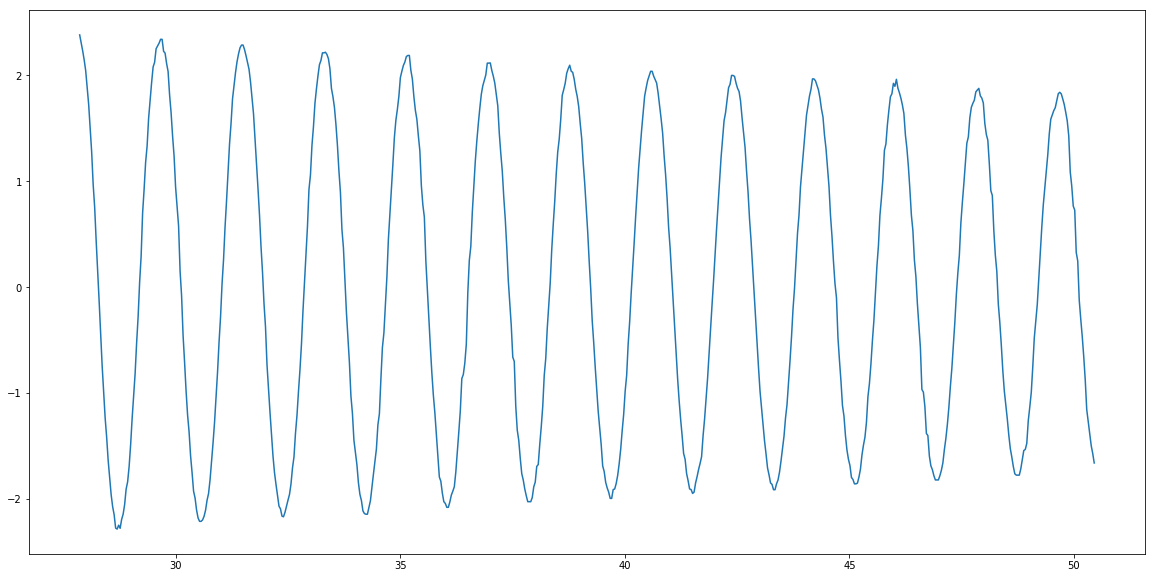

In [19]:
window = 1
edge = int(np.ceil(window/2))

def preprocess(data):
    # Calculate the moving average
    data = data.rolling(window=window,center=True).mean()
    # Trim the data that wasn't part of the moving average
    data = data[edge:-edge]
    # Standardize the data
    return preprocessing.scale(data) 

time_data = raw_data["VideoAnalysis: Time (s)"][edge:-edge].values
X_data = preprocess(raw_data["VideoAnalysis: X"])
Y_data = preprocess(raw_data["VideoAnalysis: Y"])

a = 2
b = 680
data = np.array(X_data[a:b])
time = time_data[a:b]
plt.figure(figsize=(20,10))
# plt.plot(x)
plt.plot(time, data)

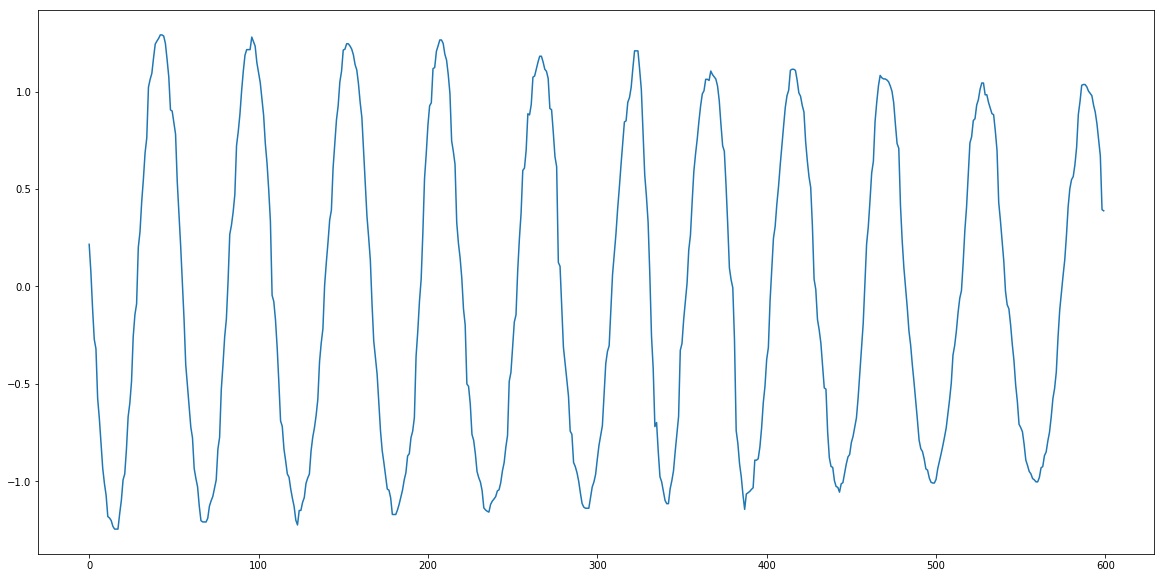

In [20]:
c = 700
d = 1300
data1 = X_data[c:d]
time1 = time_data[c:d]
plt.figure(figsize=(20,10))
# plt.plot(x)
plt.plot(data1)

In [21]:
# hyperparameters
DATA_DIM = 1
N_PREV = 55 # number of previous steps used to predict the next step

In [22]:
def _load_data(data, n_prev=N_PREV, is_shuffled=False):
    docX, docY = [], []
    for j in range(len(data)-n_prev):
        docX.append(data[j:j+n_prev])
        docY.append(data[j+n_prev])   
    alsX = np.array(docX)
    alsY = np.array(docY)
    if is_shuffled: 
        alsX, alsY = shuffle(alsX, alsY)

    return alsX.reshape(alsX.shape[0], alsX.shape[1], DATA_DIM), alsY.reshape(alsY.shape[0], DATA_DIM)

def train_test_split(data, test_size=0.6):  
    """
    This just splits data to training and testing parts
    """
    ntrn = int(round(len(data) * (1 - test_size)))

    X_train, y_train = _load_data(data[0:ntrn], is_shuffled=True)
    X_test, y_test = _load_data(data[ntrn:])

    return (X_train, y_train), (X_test, y_test)


# retrieve data
(X_train, y_train), (X_test, y_test) = train_test_split(data, 0.1)

# extra data
# (X_train1, y_train1), (X_test1, y_test1) = train_test_split(data1, 0.1)
# X_train = np.append(X_train, X_train1, axis=0)
# y_train = np.append(y_train, y_train1, axis=0)
# X_train, y_train = shuffle(X_train, y_train)

In [33]:
# define model structure
model = Sequential()
model.add(Bidirectional(CuDNNLSTM(units=200, return_sequences=True), input_shape=(None, DATA_DIM)))
model.add(Bidirectional(CuDNNLSTM(units=100, return_sequences=True)))
model.add(Bidirectional(CuDNNLSTM(units=50, return_sequences=False)))
# model.add(Bidirectional(CuDNNLSTM(units=10, return_sequences=False)))
model.add(Dense(units=1, activation="linear"))
model.compile(loss="mean_squared_error", optimizer="adam")

In [34]:
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
history = model.fit(X_train, y_train, batch_size=32, epochs=29, validation_split=0.05)

Train on 527 samples, validate on 28 samples
Epoch 1/29
527/527 [==============================] - 2s 3ms/step - loss: 0.3832 - val_loss: 0.0323
Epoch 2/29
527/527 [==============================] - 1s 2ms/step - loss: 0.0110 - val_loss: 0.0090
Epoch 3/29
527/527 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0079
Epoch 4/29
527/527 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 5/29
527/527 [==============================] - 1s 2ms/step - loss: 0.0035 - val_loss: 0.0045
Epoch 6/29
527/527 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0046
Epoch 7/29
527/527 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 8/29
527/527 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0042
Epoch 9/29
527/527 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0057
Epoch 10/29
527/527 [==============================] - 

dict_keys(['val_loss', 'loss'])
29


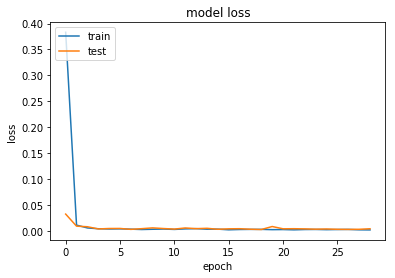

In [35]:
print(history.history.keys())
print(len(history.history['val_loss']))
# summarize history for loss
plt.plot(history.history['loss'][-40:])
plt.plot(history.history['val_loss'][-40:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
# evaluate model fit
test_prediction = model.predict(X_test)
# score = model.evaluate(X_test, y_test)
# evaluate
print('Test score:', np.mean((test_prediction-y_test)**2))

Test score: 0.002514877058906704


In [37]:
# generate the time axis for visualization
t_step = np.mean(time[1:]-time[:-1])
t_start = time[-len(y_test)]

def gen_time(data):
    t = np.arange(t_start, t_start+len(data)*t_step, t_step)
    return t

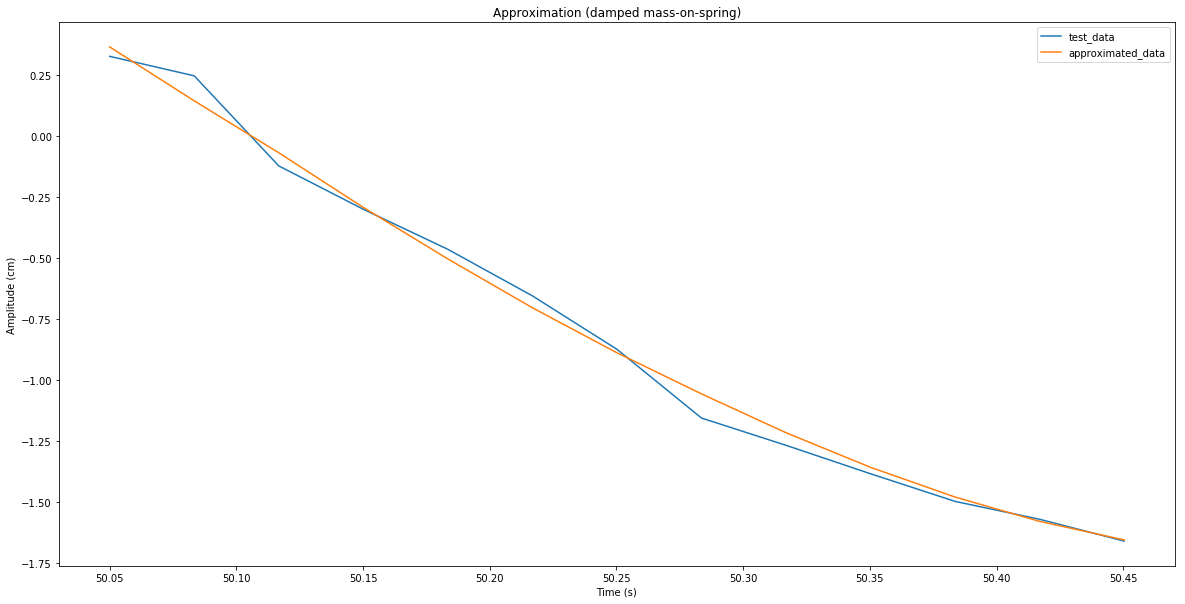

In [38]:
# visualize approximation performance on test data set
t1 = gen_time(y_test)

plt.figure(figsize=(20,10))
plt.plot(t1[:len(y_test)], y_test[:], label='test_data')
plt.plot(t1[:len(y_test)], test_prediction[:], label='approximated_data')
plt.title('Approximation (damped single pendulum)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (cm)')
plt.legend()

In [39]:
# perform modelling
X_model = data[0:N_PREV]
modelled_data = list(data[0:N_PREV])
dims = 1, X_model.shape[0], DATA_DIM
for i in range(len(data)*3):
    prev_steps = X_model.reshape(*dims)
    next_step = model.predict(prev_steps)
    modelled_data.append(next_step[0])
    X_model = np.append(X_model[1:], next_step)
    
# evaluate
modelled_data = np.append(data[0:N_PREV], np.array(modelled_data), axis=0)
print('Prediction score:', np.mean((modelled_data[:len(data)]-data)**2))

Prediction score: 0.2090727365818545


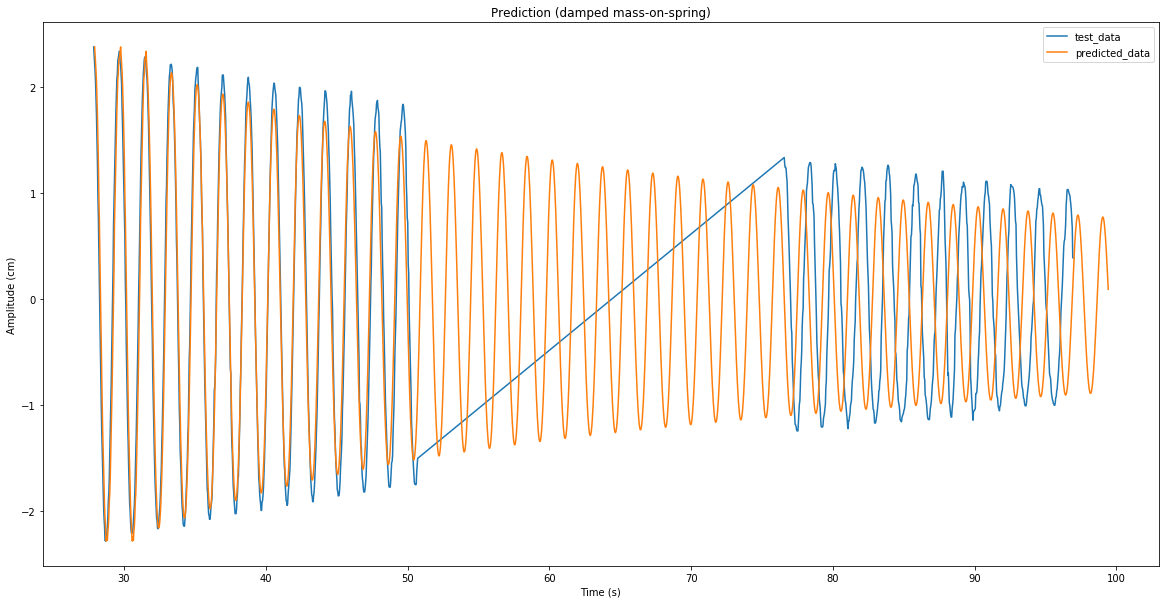

In [40]:
# visualize prediction performance
t_start = time[a]
t2 = np.arange(t_start, t_start+len(modelled_data)*t_step, t_step)

plt.figure(figsize=(20,10))
plt.plot(time_data[a:d], X_data[a:d], label='test_data')
plt.plot(t2[:len(modelled_data)], modelled_data[:], label='predicted_data')
plt.title('Prediction (damped single pendulum)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (cm)')
plt.legend()

In [31]:
# visualize approximations
train_prediction = model.predict(X_train)

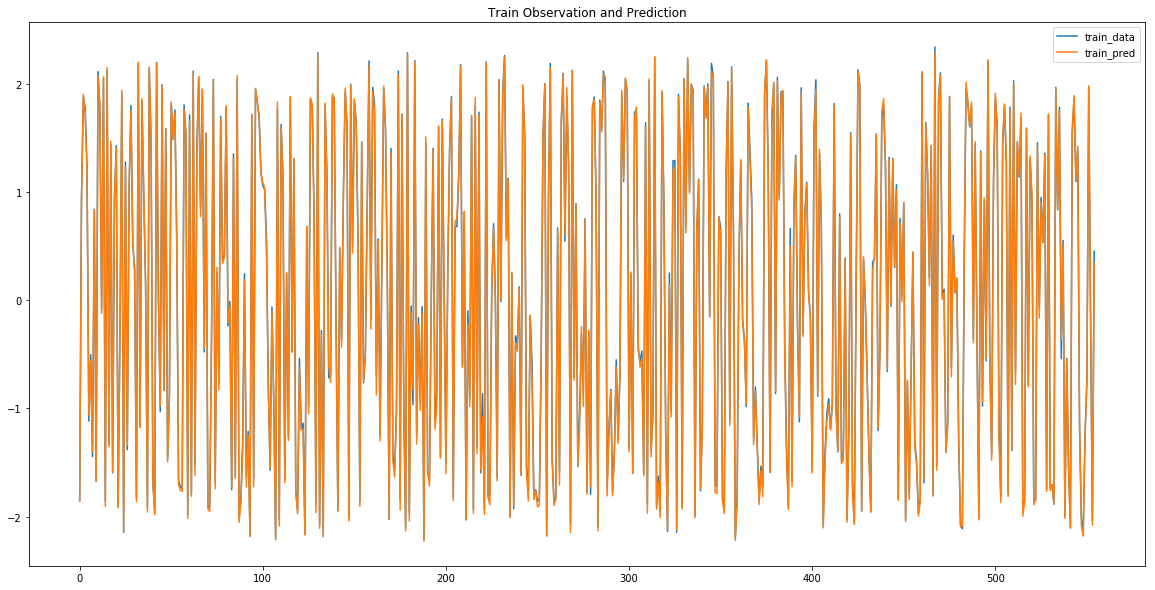

In [32]:
plt.figure(figsize=(20,10))
plt.plot(y_train[:], label='train_data')
plt.plot(train_prediction[:], label='train_pred')
plt.title('Train Observation and Prediction')
plt.legend()